# Environment Set up

In [136]:
import pandas as pd
import folium
import base64
from geopy.distance import geodesic, distance
from geopy import Point
from IPython.display import display

# Lorawan Packet Test

This test was conducted to evaluate our rpi.lorawan compute's lorawan signal distance. Three packet sizes were used (16, 32, 64 bytes). Each packet size was sent in three different data rates (DR1,DR2, DR3). DR0 was not used because the maximum payload size is 11 bytes (in most cases this is too small). The packet with 64 bytes only used DR2 and DR3 since DR1 maximum payload size is 53 bytes. In this test we used lorawan Region US915 MAC version 1.0.2 Regional Parameters revision A. Each combination of payload size and data rate was sent three times. For example, packet with 16 bytes in DR1 was sent three times. 

rpi.lorawan consist of rasberry pi with a pi hat connected to a rak wireless concentrator. The antenna we used was 5.8dBi Fiberglass Antenna from RAK. Below are the links to the hardware:
- [rpi.lorawan Compute](https://store.rakwireless.com/products/rak-discover-kit-2?variant=39942870302918)
    - frequency: US915
    - version: 4GB RPI4
- [Lorawan Antenna](https://store.rakwireless.com/products/5-8dbi-fiber-glass-antenna?variant=41100723912902)
    - Gain: 5.8 dBi 
    - frequency: 902-928MHz
    - connector type: iPEX

Our Lorawan sensor consisted of an arduino mkrwan 1310 programmed to send all of the different packet sizes and date rates. Look at [main.ino](./src/main/main.ino) for the source code. Below is a link to the hardware:
- [Arduino MKR WAN 1310](https://store-usa.arduino.cc/products/arduino-mkr-wan-1310)
- [Micro-USB to USB](https://www.amazon.com/Android-Compatible-Smartphones-Charging-Stations/dp/B095JZSHXQ)
- [Male to Male Jumper Wires](https://www.amazon.com/Solderless-Multicolored-Electronic-Breadboard-Protoboard/dp/B09FP517VM)
- [Breadboard](https://www.adafruit.com/product/65)
- [28x64 OLED display](https://www.amazon.com/UCTRONICS-SSD1306-Self-Luminous-Display-Raspberry/dp/B072Q2X2LL)

>NOTE: Payload sizes more than 80 bytes did not work with the arduino mkrwan 1310. The most likely case of this is because the arduino was not outputting enough power to transmit packets higher than 80 bytes. The lorawan specifications allows more than 80 bytes in spreading factor 8 and 7 so it is possible to send more than 80 bytes if the lorawan device is capable of it.

The process involved driving or walking to each location and starting the arduino so that it can join and send packets to the network. The day we performed the test included no rain and slight cloudy sky. It had rain in the morning but not during the test. The landscape is slightly urbanized with some space in between buildings. Look at the final map to see more details of the landscape.

>NOTE: The environment plays a huge factor in the range of the lorawan signal, so it is possible for the range to increase if the test is conducted again at a nother location. Since this test was done in an urban area with buildings in between our lorawan sensor and gateway, take this as a middle ground. If your deployment is in a rural area the range will most likely increase. On the other hand, if your deployment is in a more urbanize area (more buildings) than the range will more likely decrease.

Finally, our gateway was ~1.24m above the ground. The antenna should have been higher up but we did not have an available tower to deploy our gateway at a higher altitude. Keeping this in mind, the range would have been larger if the antenna was higher up the ground.

>Use this test as a middle ground for your deployment of the rpi.lorawan compute.



![rpi.lorawan compute](./images/rpi_lorawan.jpg)

## Data Visualization

To packet results were retrieved and processed using [get.py](./data/get.py). To look at individual data files such as the device and gateway locations see the [data folder](./data).


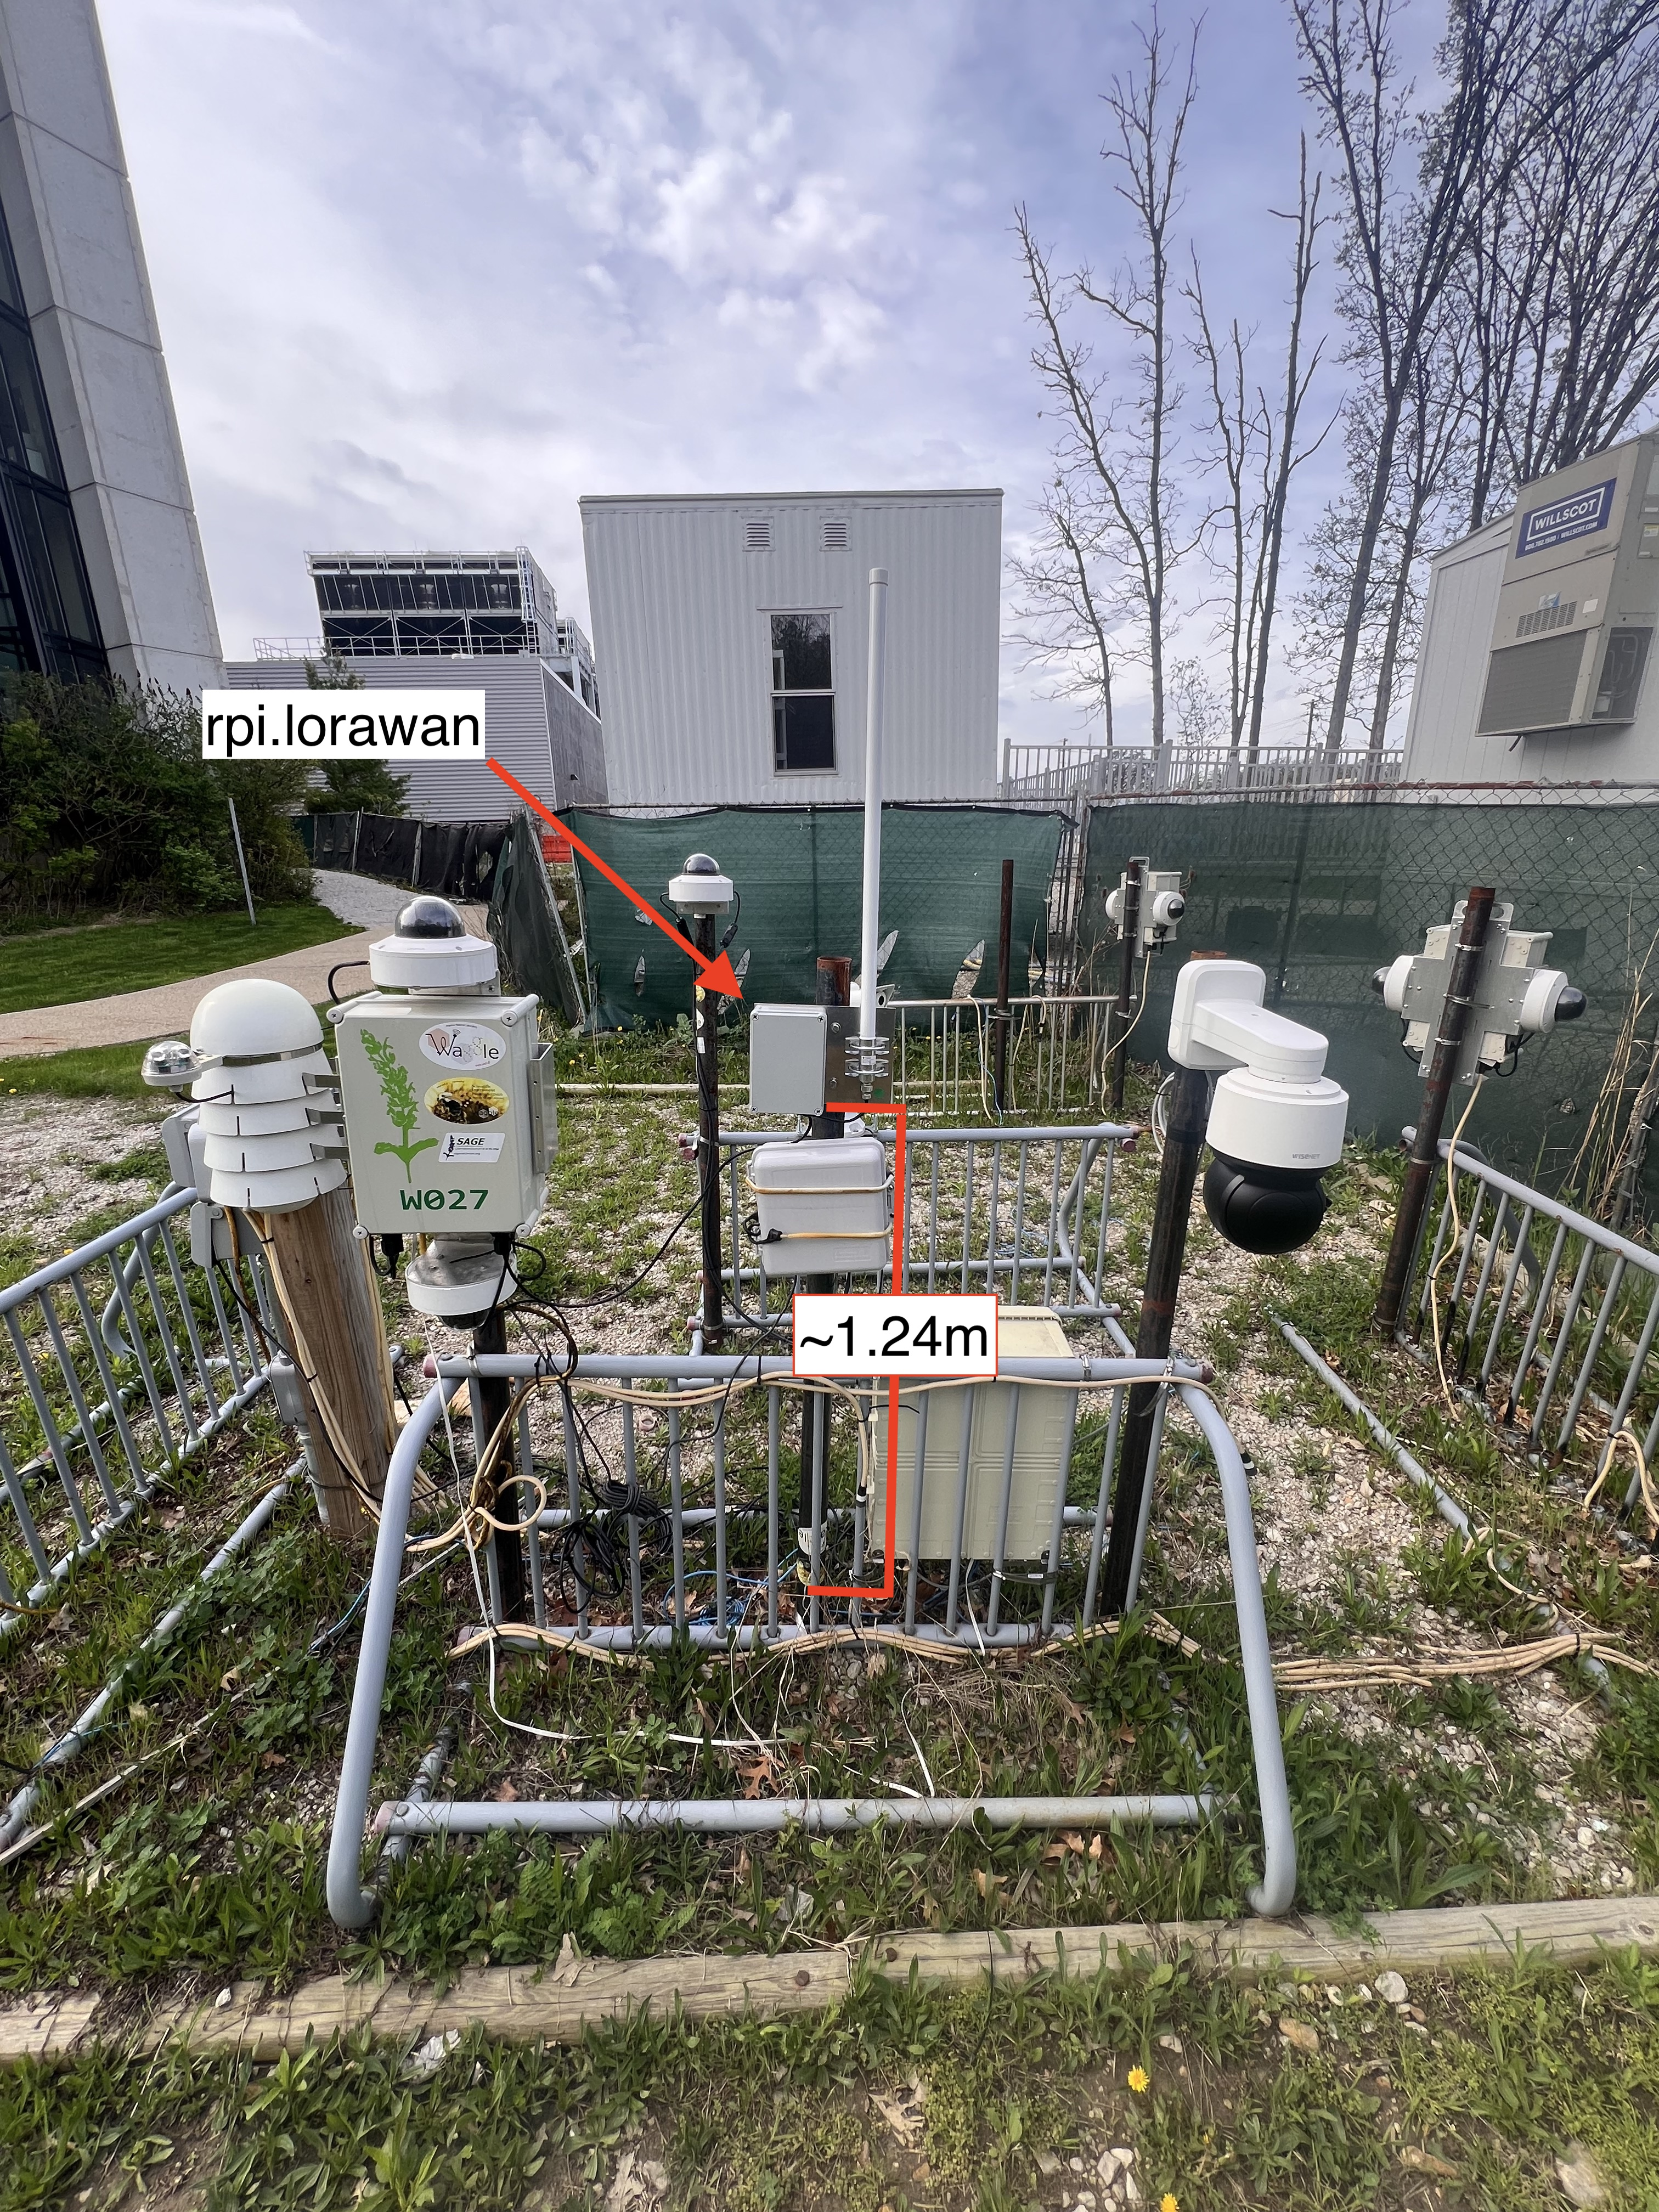

In [137]:
# Load into DataFrame
df = pd.read_csv("data/processed.csv")
gw_df = pd.read_csv("data/gw_location.csv")
loc = pd.read_csv("data/locations.csv")
failed_df = loc[loc["success"] == "false"].reset_index(drop=True)

# Gateway location
gw_loc = (gw_df['lat(EPSG:4326)'][0], gw_df['long(EPSG:4326)'][0])

# Group by location (lat, lon)
location_groups = df.groupby(['lat(EPSG:4326)', 'long(EPSG:4326)'])

# Create folium map
m = folium.Map(location=gw_loc, zoom_start=14)

# Path to local image
image_path = './images/rpi_lorawan.jpg'

# Encode image to base64
with open(image_path, 'rb') as image_file:
    encoded = base64.b64encode(image_file.read()).decode()

# Add gateway locations to the map with image
folium.Marker(
    location=gw_loc,
    tooltip="<b>Lorawan Gateway</b>, click for more info...",
    icon=folium.Icon(icon='feed', prefix="fa"),
    popup=folium.Popup(
        f'<img src="data:image/jpeg;base64,{encoded}" width="300px">',
        max_width=300
    )
).add_to(m)

# Define all expected (packet_size, spreading_factor) combinations
expected_combinations = [
    (16, 7), (16, 8), (16, 9),
    (32, 7), (32, 8), (32, 9),
    (64, 7), (64, 8)
]

# Variable to track the maximum distance
max_distance_meters = 0

for (lat, lon), location_df in location_groups:
    # Calculate distance from gateway (in meters)
    to_gw = geodesic(gw_loc, (lat, lon)).meters

    # Update maximum distance
    if to_gw > max_distance_meters:
        max_distance_meters = to_gw

    # Further group by packet_size and spreading factor
    packet_groups = location_df.groupby(['packet_size', 'signal.spreadingfactor'])
    
    popup_text = ""
    
    for packet_size, spreading_factor in expected_combinations:
        # Check if this combination exists
        if (packet_size, spreading_factor) in packet_groups.groups:
            # Get the data
            packet_df = packet_groups.get_group((packet_size, spreading_factor))

            avg_rssi = packet_df['signal.rssi'].mean()
            avg_snr = packet_df['signal.snr'].mean()
            packet_loss_ratio = packet_df['signal.pl'].sum() / len(packet_df)

            popup_text += (
                f"<b>Packet Size:</b> {packet_size}, "
                f"<b>Spreading Factor:</b> {spreading_factor}, "
                f"Avg RSSI: {avg_rssi:.2f} dBm, "
                f"Avg SNR: {avg_snr:.2f} dB, "
                f"Packet Loss Ratio: {packet_loss_ratio:.2%}<br><br>"
            )
        else:
            # Combination missing: assume 100% packet loss
            popup_text += (
                f"<b>Packet Size:</b> {packet_size}, "
                f"<b>Spreading Factor:</b> {spreading_factor}, "
                f"Packet Loss Ratio: 100%<br><br>"
            )
    
    # Add marker
    folium.Marker(
        location=[lat, lon],
        tooltip=f"<b>Distance to gw:</b> {to_gw:.1f} m, click for more info...",
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='green')
    ).add_to(m)

# Add locations that failed to join
for index, row in failed_df.iterrows():
    lat = row['lat(EPSG:4326)']
    lon = row['long(EPSG:4326)']

    # Calculate distance from gateway (in meters)
    to_gw = geodesic(gw_loc, (lat, lon)).meters

    # Add marker
    folium.Marker(
        location=[lat, lon],
        tooltip=f"<b>Distance to gw:</b> {to_gw:.1f} m, Failed to join",
        icon=folium.Icon(color='red')
    ).add_to(m)

# Draw a dashed circle at the gateway with radius = farthest point
folium.Circle(
    location=gw_loc,
    radius=max_distance_meters,
    color='black',
    weight=2,
    fill=False,
    dash_array='10, 10'  # Dash style: 10 pixels on, 10 pixels off
).add_to(m)

# Calculate the point "max_distance_meters" to the west (bearing 270 degrees)
gw_point = Point(gw_loc[0], gw_loc[1])
west_point = distance(meters=max_distance_meters).destination(point=gw_point, bearing=270)
west_loc = (west_point.latitude, west_point.longitude)

# Draw the radius line
folium.PolyLine(
    locations=[gw_loc, west_loc],
    color='black',
    weight=2,
    dash_array='5, 5'
).add_to(m)

# Add a label in the middle of the line
mid_lat = (gw_loc[0] + west_loc[0]) / 2
mid_lon = (gw_loc[1] + west_loc[1]) / 2
folium.Marker(
    location=[mid_lat, mid_lon],
    icon=folium.DivIcon(html=f"""
        <div style="font-size: 12pt; color: black;">{max_distance_meters:.1f}m</div>
        """)
).add_to(m)

# Create a custom legend
legend_html = """
<div style="
    position: fixed;
    top: 20px; right: 20px; width: 180px; height: 100px;
    background-color: white;
    border:2px solid grey; z-index:9999; font-size:14px;
    padding: 10px;
    ">
<b>Legend</b><br>
🔵 <b>Lorawan Gateway</b><br>
🟢🔴 <b>Device Locations</b><br>
⚫️ <b>Max Range</b> (dashed)<br>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

display(m)

>NOTE: 
> - Spreading Factor 9 (DR1): The maximum payload size is 53 bytes
> - Spreading Factor 8 (DR2): The maximum payload size is 125 bytes
> - Spreading Factor 7 (DR3): The maximum payload size is 222 bytes

In [138]:
# Save to HTML
m.save('html/lorawan_packet_map.html')

## Results

Looking at the map, anything lower than 1129.8m from the gateway successfully joined and sent packets. If we click into the Device Location markers we can see which sizes did better and in what data rates. For example at a distance 1129.8m away from the gateway, packet size 64 bytes in Spreading Factor 8 (DR2) we lost 1/3 of the packets but in Spreading Factor 7 (DR3) we lost none. Using these results we can get a general sense of how well our rpi.lorawan compute does in range in varying data rates and packet sizes. When looking at this map keep in mind each deployment location can have different results, look at these results do get a general idea of how well the rpi.lorawan does.